Failed to import precision_recall_f1_support. Falling back to precision_score, recall_score, f1_score.
2.6.0+cu124
0.21.0+cu124
cuda
<class 'torchvision.datasets.cifar.CIFAR10'>
50000 10000
torch.Size([3, 32, 32]) torch.float32
4
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv

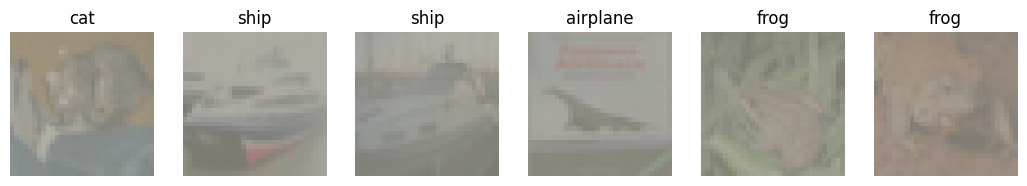

GroundTruth:  ['cat'] ['ship'] ['ship'] ['airplane'] ['frog'] ['frog']
Predicted:  ['cat'] ['ship'] ['automobile'] ['airplane'] ['frog'] ['frog']

Final Test Metrics:
Test Loss: 0.2797
Test Accuracy: 0.934

Per-Class Metrics:
airplane: Precision=0.941, Recall=0.937, F1-Score=0.939
automobile: Precision=0.949, Recall=0.982, F1-Score=0.965
bird: Precision=0.904, Recall=0.934, F1-Score=0.919
cat: Precision=0.877, Recall=0.859, F1-Score=0.868
deer: Precision=0.933, Recall=0.936, F1-Score=0.935
dog: Precision=0.890, Recall=0.892, F1-Score=0.891
frog: Precision=0.972, Recall=0.937, F1-Score=0.954
horse: Precision=0.947, Recall=0.963, F1-Score=0.955
ship: Precision=0.965, Recall=0.954, F1-Score=0.959
truck: Precision=0.967, Recall=0.949, F1-Score=0.958

Macro-Averaged: Precision=0.934, Recall=0.934, F1-Score=0.934


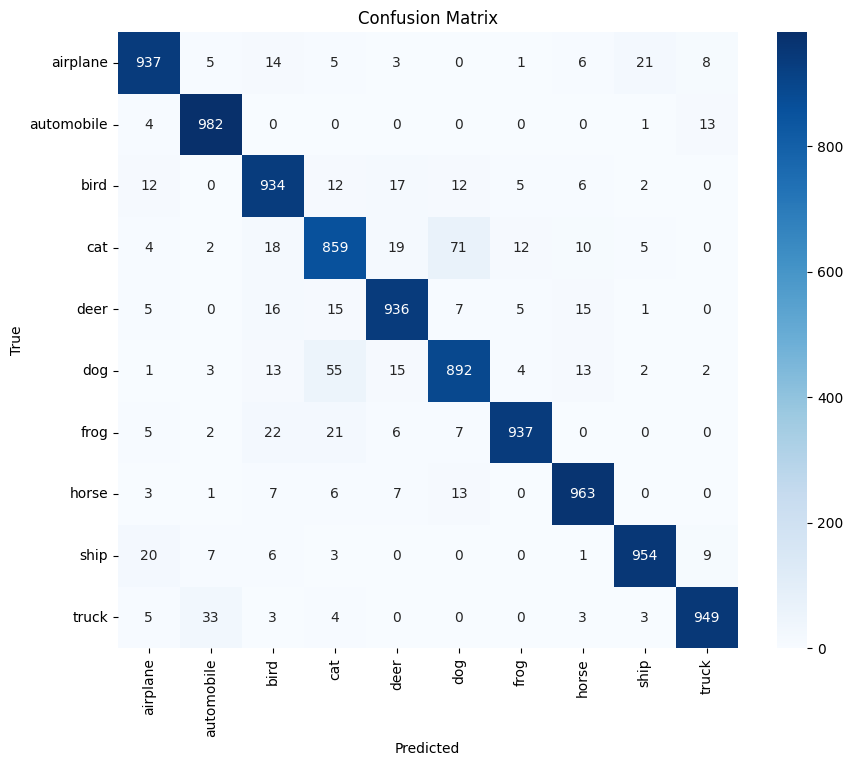

<Figure size 640x480 with 0 Axes>

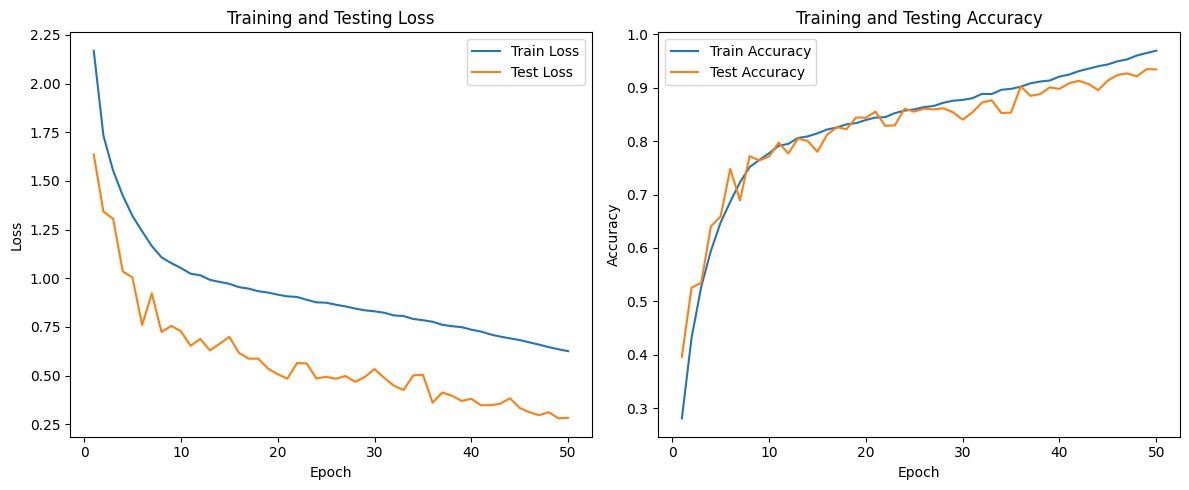

<Figure size 640x480 with 0 Axes>

In [1]:
import os
import time
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast  # Updated AMP import
try:
    from sklearn.metrics import precision_recall_f1_support, confusion_matrix
    USE_PRF1_SUPPORT = True
    print("Imported precision_recall_f1_support successfully")
except ImportError:
    print("Failed to import precision_recall_f1_support. Falling back to precision_score, recall_score, f1_score.")
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    USE_PRF1_SUPPORT = False
try:
    import seaborn as sns
except ImportError:
    print("ImportError: seaborn not found. Please install using: pip install seaborn")
    raise

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)  # Expected: 2.6.0+cu124
print(torchvision.__version__)  # Expected: 0.21.0+cu124
print(device)  # Expected: cuda

# Cell 3: Dataset Acquisition and Preprocessing (CIFAR-10)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train = torchvision.datasets.CIFAR10(root='/content/CIFAR10', train=True, download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10(root='/content/CIFAR10', train=False, download=True, transform=transform_test)

print(type(cifar10_train))
print(len(cifar10_train), len(cifar10_test))

feature, label = cifar10_train[3]
print(feature.shape, feature.dtype)
print(label)

def get_CIFAR10_labels(labels):
    text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]
print(get_CIFAR10_labels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

def show_cifar10(images, labels):
    plt.figure(figsize=(13, 13))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(lbl)
        plt.axis('off')
    plt.show()

# Cell 4: Define ResNet-18 Model
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.5)  # Increased dropout
        self.linear = nn.Linear(512 * block.expansion, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

net = ResNet(BasicBlock, [2, 2, 2, 2])
print(net)

# Cell 5: Training Preparation
batch_size = 128
train_iter = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(cifar10_test, batch_size=100, shuffle=False, num_workers=2)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

def evaluate_metrics(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    acc_sum, loss_sum, n = 0.0, 0.0, 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            net.eval()
            outputs = net(X)
            loss = loss_fn(outputs, y)
            preds = outputs.argmax(dim=1)
            acc_sum += (preds == y).float().sum().cpu().item()
            loss_sum += loss.cpu().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            net.train()
            n += y.shape[0]
    avg_loss = loss_sum / n
    avg_acc = acc_sum / n
    return avg_loss, avg_acc, all_preds, all_labels

class LabelSmoothingLoss(nn.Module):  # Added label smoothing
    def __init__(self, smoothing=0.1, classes=10):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.classes = classes
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred).fill_(self.smoothing / (self.classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

def train(net, train_iter, test_iter, batch_size, optimizer, scheduler, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss_fn = LabelSmoothingLoss(smoothing=0.1)  # Updated loss
    scaler = GradScaler('cuda')  # Fixed AMP
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    best_test_loss = float('inf')  # Early stopping on test loss
    patience, counter = 10, 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast('cuda'):  # Fixed AMP
                y_hat = net(X)
                l = loss_fn(y_hat, y)
            scaler.scale(l).backward()
            scaler.step(optimizer)
            scaler.update()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_loss, test_acc, _, _ = evaluate_metrics(test_iter, net)
        train_losses.append(train_l_sum / batch_count)
        train_accs.append(train_acc_sum / n)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'epoch {epoch + 1}, train loss {train_losses[-1]:.4f}, train acc {train_accs[-1]:.3f}, '
              f'test loss {test_losses[-1]:.4f}, test acc {test_accs[-1]:.3f}, time {time.time() - start:.1f} sec')
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(net.state_dict(), '/content/drive/MyDrive/best_model.pth')
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
        scheduler.step()
    return train_losses, train_accs, test_losses, test_accs

# Cell 6: Train the Model
lr, num_epochs = 0.1, 50  # Reduced epochs
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)  # Increased weight decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)  # Adjusted T_max
train_losses, train_accs, test_losses, test_accs = train(net, train_iter, test_iter, batch_size, optimizer, scheduler, device, num_epochs)

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
torch.save(net.state_dict(), '/content/drive/MyDrive/mymodel.pth')

# Cell 7: Model Validation and Metrics
net.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth'))

cifar10_train = torchvision.datasets.CIFAR10(root='/content/CIFAR10', train=True, download=True, transform=transforms.ToTensor())
cifar10_test = torchvision.datasets.CIFAR10(root='/content/CIFAR10', train=False, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(cifar10_train, batch_size=6, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(cifar10_test, batch_size=6, shuffle=False, num_workers=2)

cifar10_train_tran = torchvision.datasets.CIFAR10(root='/content/CIFAR10', train=True, download=True, transform=transform_train)
cifar10_test_tran = torchvision.datasets.CIFAR10(root='/content/CIFAR10', train=False, download=True, transform=transform_test)
train_iter_tran = torch.utils.data.DataLoader(cifar10_train_tran, batch_size=6, shuffle=True, num_workers=2)
test_iter_tran = torch.utils.data.DataLoader(cifar10_test_tran, batch_size=6, shuffle=False, num_workers=2)

dataiter = iter(test_iter)
images, labels = next(dataiter)
show_cifar10(images, get_CIFAR10_labels(labels))
print('GroundTruth: ', ' '.join(f'{get_CIFAR10_labels([labels[j].numpy()])}' for j in range(6)))

dataiter_tran = iter(test_iter_tran)
images_tran, labels_tran = next(dataiter_tran)
images_tran, labels_tran = images_tran.to(device), labels_tran.to(device)
outputs = net(images_tran)
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join(f'{get_CIFAR10_labels([predicted[j].cpu().numpy()])}' for j in range(6)))

test_loss, test_acc, all_preds, all_labels = evaluate_metrics(test_iter_tran, net)
if USE_PRF1_SUPPORT:
    precision, recall, f1, _ = precision_recall_f1_support(all_labels, all_preds, average=None)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_f1_support(all_labels, all_preds, average='macro')
else:
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

print("\nFinal Test Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.3f}")
print("\nPer-Class Metrics:")
for i, label in enumerate(get_CIFAR10_labels(range(10))):
    print(f"{label}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-Score={f1[i]:.3f}")
print(f"\nMacro-Averaged: Precision={macro_precision:.3f}, Recall={macro_recall:.3f}, F1-Score={macro_f1:.3f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=get_CIFAR10_labels(range(10)), yticklabels=get_CIFAR10_labels(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')

# Cell 8: Plot Training and Testing Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/metrics_plot.png')